In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
testDf = pd.read_csv('test.csv', index_col=0)
trainDf = pd.read_csv('train.csv', index_col=0)

In [3]:
trainDf.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


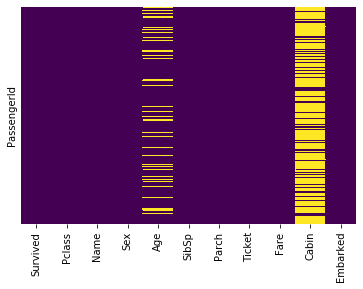

In [4]:
sns.heatmap(trainDf.isnull(),yticklabels=False,cbar=False,cmap='viridis')
#Lots of missing data in Cabin and Age
#No cabin data=they did not stay in cabins!
#Impute Age

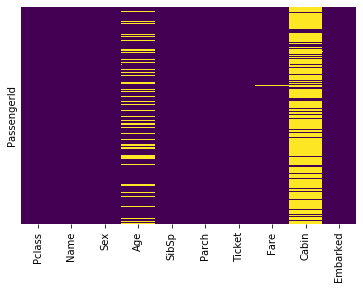

In [5]:
sns.heatmap(testDf.isnull(),yticklabels=False,cbar=False,cmap='viridis')
#same for test data, lots of missing Age and Cabin, even fare
#Impute Age and Fare

In [6]:
# Learned this from Niklas Donges, no cabin is U0
trainDf['Cabin'].fillna('U0', inplace=True)
testDf['Cabin'].fillna('U0', inplace=True)

In [7]:
import re
deck = {'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7, 'U': 8}

trainDf['Deck'] = trainDf['Cabin'].map(lambda x: re.compile("([a-zA-Z]+)").search(x).group())
trainDf['Deck'] = trainDf['Deck'].map(deck)
trainDf['Deck'] = trainDf['Deck'].fillna(0)
trainDf['Deck'] = trainDf['Deck'].astype(int)
trainDf.drop('Cabin',axis=1,inplace=True)

In [8]:
deck = {'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7, 'U': 8}

testDf['Deck'] = testDf['Cabin'].map(lambda x: re.compile("([a-zA-Z]+)").search(x).group())
testDf['Deck'] = testDf['Deck'].map(deck)
testDf['Deck'] = testDf['Deck'].fillna(0)
testDf['Deck'] = testDf['Deck'].astype(int)
testDf.drop('Cabin',axis=1,inplace=True)

In [9]:
# Train Test Split
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(trainDf.drop(['Name','Survived','Ticket'],axis=1), trainDf['Survived'], test_size=0.3)

In [10]:
# Impute on training Data
from sklearn.impute import SimpleImputer
imputer = SimpleImputer()
imputed_X_train = pd.DataFrame(imputer.fit_transform(X_train[['Age']]), index=X_train.index)
imputed_X_valid = pd.DataFrame(imputer.transform(X_valid[['Age']]), index=X_valid.index)
imputed_X_train.columns = ['Age']
imputed_X_valid.columns = ['Age']
imputed_X_train = pd.concat([X_train.drop('Age', axis=1), imputed_X_train], axis = 1)
imputed_X_valid = pd.concat([X_valid.drop('Age', axis=1), imputed_X_valid], axis = 1)

In [11]:
imputed_X_train.head()

,Pclass,Sex,SibSp,Parch,Fare,Embarked,Deck,Age
PassengerId,,,,,,,,
850,1,female,1,0,89.1042,C,3,29.811395
555,3,female,0,0,7.7750,S,8,22.000000
829,3,male,0,0,7.7500,Q,8,29.811395
653,3,male,0,0,8.4333,S,8,21.000000
538,1,female,0,0,106.4250,C,8,30.000000


In [12]:
# Impute on testing Data
imputed_X_test = pd.DataFrame(imputer.fit_transform(testDf[['Age', 'Fare']]), index=testDf.index)
imputed_X_test.columns = ['Age','Fare']
imputed_X_test = pd.concat([testDf.drop(['Name','Age','Fare','Ticket'], axis=1), imputed_X_test], axis = 1)

In [13]:
imputed_X_test.head()

,Pclass,Sex,SibSp,Parch,Embarked,Deck,Age,Fare
PassengerId,,,,,,,,
892,3,male,0,0,Q,8,34.5,7.8292
893,3,female,1,0,S,8,47.0,7.0000
894,2,male,0,0,Q,8,62.0,9.6875
895,3,male,0,0,S,8,27.0,8.6625
896,3,female,1,1,S,8,22.0,12.2875


In [14]:
#Create Labeled Data
object_cols = [col for col in imputed_X_train.columns if imputed_X_train[col].dtype == 'object']
good_label_cols = [col for col in object_cols if set(imputed_X_train[col])==set(imputed_X_valid[col])]
bad_label_cols = list(set(object_cols)-set(good_label_cols))
label_X_train = imputed_X_train.drop(bad_label_cols, axis=1)
label_X_valid = imputed_X_valid.drop(bad_label_cols, axis=1)

In [15]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
for col in good_label_cols:
    label_X_train[col] = le.fit_transform(imputed_X_train[col].astype(str))
    label_X_valid[col] = le.transform(imputed_X_valid[col].astype(str))
label_X_train

,Pclass,Sex,SibSp,Parch,Fare,Deck,Age
PassengerId,,,,,,,
850,1,0,1,0,89.1042,3,29.811395
555,3,0,0,0,7.7750,8,22.000000
829,3,1,0,0,7.7500,8,29.811395
653,3,1,0,0,8.4333,8,21.000000
538,1,0,0,0,106.4250,8,30.000000
...,...,...,...,...,...,...,...
120,3,0,4,2,31.2750,8,2.000000
570,3,1,0,0,7.8542,8,32.000000
503,3,0,0,0,7.6292,8,29.811395


In [17]:
label_X_test = imputed_X_test.drop(bad_label_cols, axis=1)
for col in good_label_cols:
    label_X_test[col] = le.fit_transform(imputed_X_test[col].astype(str))
label_X_test

,Pclass,Sex,SibSp,Parch,Deck,Age,Fare
PassengerId,,,,,,,
892,3,1,0,0,8,34.50000,7.8292
893,3,0,1,0,8,47.00000,7.0000
894,2,1,0,0,8,62.00000,9.6875
895,3,1,0,0,8,27.00000,8.6625
896,3,0,1,1,8,22.00000,12.2875
...,...,...,...,...,...,...,...
1305,3,1,0,0,8,30.27259,8.0500
1306,1,0,0,0,3,39.00000,108.9000
1307,3,1,0,0,8,38.50000,7.2500


In [18]:
# Create Model
from xgboost import XGBClassifier
model = XGBClassifier(early_stopping_rounds=5,
                     eval_set=[(label_X_valid, y_valid)],
                     verbose=False)
model.fit(label_X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, early_stopping_rounds=5,
              eval_set=[(             Pclass  Sex  SibSp  Parch      Fare  Deck        Age
PassengerId                                                      
245               3    1      0      0    7.2250     8  30.000000
644               3    1      0      0   56.4958     8  29.811395
767               1    1      0      0   39.6000     8  29.811395
323               2    0      0      0   12.3500     8  30.000000
361               3    1      1      4   27.9000     8  40.000000
...             ...  ...    ...    ...       ...   ...        ...
577               2    0      0      0   13.0000     8  34.000000
326...
245    0
644    1
767    0
323    1
361    0
      ..
577    1
326    1
49     0
224    0
733    0
Name: Survived, Length: 268, dtype: int64)],
              gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
         

In [52]:
#tuning XGBC
model = XGBClassifier(learning_rate=0.01,
                      n_estimators=100,
                      max_depth=3,
                      subsample=0.8,
                      colsample_bytree=1,
                      gamma= 1,
                      eval_set=[(label_X_valid, y_valid)],
                      verbose=False)
model.fit(label_X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1,
              eval_set=[(             Pclass  Sex  SibSp  Parch      Fare  Deck        Age
PassengerId                                                      
245               3    1      0      0    7.2250     8  30.000000
644               3    1      0      0   56.4958     8  29.811395
767               1    1      0      0   39.6000     8  29.811395
323               2    0      0      0   12.3500     8  30.000000
361               3    1      1      4   27.9000     8  40.000000
...             ...  ...    ...    ...       ...   ...        ...
577               2    0      0      0   13.0000     8  34.000000
326               1    0      0      0  135.6333     3  36.000000
49...
644    1
767    0
323    1
361    0
      ..
577    1
326    1
49     0
224    0
733    0
Name: Survived, Length: 268, dtype: int64)],
              gamma=1, learning_rate=0.01, max_delt

In [53]:
pred = model.predict(label_X_valid)

In [54]:
# metrics
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_valid, pred))
print(confusion_matrix(y_valid, pred))

              precision    recall  f1-score   support

           0       0.85      0.89      0.87       170
           1       0.80      0.72      0.76        98

    accuracy                           0.83       268
   macro avg       0.82      0.81      0.82       268
weighted avg       0.83      0.83      0.83       268

[[152  18]
 [ 27  71]]


In [21]:
full_X = pd.concat([label_X_train,label_X_valid],axis=0)
full_X.sort_index(inplace=True)

full_y = pd.concat([y_train,y_valid],axis=0)
full_y.sort_index(inplace=True)

PassengerId
1      0
2      1
3      1
4      1
5      0
      ..
887    0
888    1
889    0
890    1
891    0
Name: Survived, Length: 891, dtype: int64

In [25]:
label_X_test = label_X_test[full_X.columns]

In [55]:
# train model on full training set
model = XGBClassifier(learning_rate=0.01,
                      n_estimators=100,
                      max_depth=3,
                      subsample=0.8,
                      colsample_bytree=1,
                      gamma= 1,
                     verbose=False)
model.fit(full_X,full_y)
fullPred = model.predict(label_X_test)

In [56]:
presubmissionDf = pd.DataFrame(fullPred, columns=['Survived'])
presubmissionDf.index = np.arange(892, 892+len(presubmissionDf))
presubmissionDf = pd.concat([label_X_test,presubmissionDf], axis=1)
presubmissionDf['Name']=testDf['Name']
presubmissionDf

,Pclass,Sex,SibSp,Parch,Fare,Deck,Age,Survived,Name
892,3,1,0,0,7.8292,8,34.50000,0,"Kelly, Mr. James"
893,3,0,1,0,7.0000,8,47.00000,1,"Wilkes, Mrs. James (Ellen Needs)"
894,2,1,0,0,9.6875,8,62.00000,0,"Myles, Mr. Thomas Francis"
895,3,1,0,0,8.6625,8,27.00000,0,"Wirz, Mr. Albert"
896,3,0,1,1,12.2875,8,22.00000,1,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)"
...,...,...,...,...,...,...,...,...,...
1305,3,1,0,0,8.0500,8,30.27259,0,"Spector, Mr. Woolf"
1306,1,0,0,0,108.9000,3,39.00000,1,"Oliva y Ocana, Dona. Fermina"
1307,3,1,0,0,7.2500,8,38.50000,0,"Saether, Mr. Simon Sivertsen"
1308,3,1,0,0,8.0500,8,30.27259,0,"Ware, Mr. Frederick"


In [57]:
submissionDf=pd.DataFrame(presubmissionDf['Survived'], columns=['Survived'])
submissionDf = submissionDf.rename_axis('PassengerId')
submissionDf.to_csv('titanicSurvivorPredictions.csv')